In [13]:
from utilities.data_functions import col_to_edge_list, chromatic_numbers
from utilities.vis_helpers import plot_coloring
from algorithms.color_gcn import ColorGCN
import torch
import torch.optim as optim
from utilities.eval import WangLoss, PottsLoss, count_collisions, get_bad_edges
from utilities.helpers import get_device

device = get_device()
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4090


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from utilities.transformer_helpers import PositionalEncoding


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
#         deg = torch.sum(adj, dim=1)
#         out /= deg.view(-1, 1)
        out = self.W(out)
        return out


class JKColor(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, dropout=0.5, nheads=4):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolution(input_dim, input_dim))

        for _ in range(num_layers - 1):
            self.layers.append(GraphConvolution(input_dim, input_dim))

        self.adj_normalized = None

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=nheads)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=1)
        self.positional_encoding = PositionalEncoding(d_model=input_dim)
        self.color = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        layer_outputs = []
        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
#             x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
            x = F.relu(x)
        x = torch.stack(layer_outputs, dim=0)  
        x = self.positional_encoding(x) 
        x = self.transformer_encoder(x)
        x = x[-1] 
        x = self.color(x) 
        return x

    def _make_adj(self, edge_index):
        adj = to_dense_adj(edge_index).squeeze(0).to(edge_index.device)
        self.adj_normalized = adj


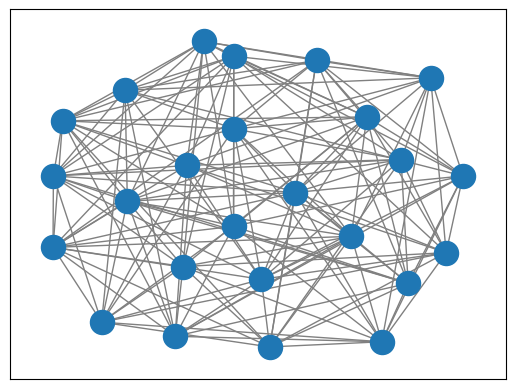

In [15]:
graph = 'queen5_5.col'
n, edge_list, col_list = col_to_edge_list(f'data/input/COLOR/instances/{graph}')
plot_coloring(edge_list)

In [16]:
print(model)

JKColor(
  (layers): ModuleList(
    (0-3): 4 x GraphConvolution(
      (W): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (color): Sequential(
    (0): Linear(in_features=64, out_fe

In [21]:
import pandas as pd
from tqdm.notebook import tqdm

# Run the graph model
best_coloring = None
fewest_collisions = 10e5
results = []
cols = ['input_dim', 'hidden_dim', 'dropout', 'use_embedding', 'lr', 'collisions']
patience = 1000

input_dim = 64
output_dim = chromatic_numbers[graph]
num_layers = 1
epochs = 100000
dropout = 0.1
use_embedding = True
lr = 1e-3

model = JKColor(input_dim, output_dim, num_layers, dropout=dropout).to(device)
edge_index = edge_list.to(device)
if use_embedding:
    embeddings = nn.Embedding(n, input_dim).to(device)
    graph_nodes = torch.arange(n).long().to(device)
else:
    graph_rep = torch.randn((n, input_dim)).to(device)
if use_embedding:
    optimizer = optim.Adam(list(model.parameters()) + list(embeddings.parameters()), lr=lr)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = PottsLoss(edge_index)
#                     loss_fn = WangLoss(edge_index, lam=.02)

prev_loss = 10e5
last_improvement = 0
for i in range(epochs):
    if last_improvement > patience:
        break
    model.train()
    optimizer.zero_grad()
    if use_embedding:
        graph_rep = embeddings(graph_nodes)
    out = model(graph_rep, edge_index)
    loss = loss_fn(out)
    loss.backward()
    optimizer.step()
    if loss < prev_loss:
        prev_loss = loss
        last_improvement = 0
    else:
        last_improvement += 1
    if i % 1000 == 0:
        model.eval()
        with torch.no_grad():
            out = model(graph_rep, edge_list)
        coloring = torch.argmax(out, dim=1)
        collisions = count_collisions(coloring, edge_list)
        # print(f'{i}: {collisions, loss}')
        if collisions == 0:
            best_coloring = coloring
            break
        if collisions < fewest_collisions:
            fewest_collisions = collisions
            best_coloring = coloring

model.eval()
with torch.no_grad():
    out = model(graph_rep, edge_list)
coloring = torch.argmax(out, dim=1)
collisions = count_collisions(coloring, edge_list)
print(collisions)



4.0


4.0


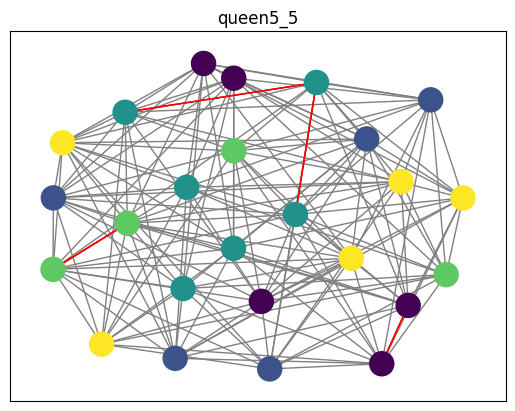

In [22]:
bad_edges = get_bad_edges(best_coloring, edge_list)
print(len(bad_edges)/2)
plot_coloring(edge_list.cpu(), best_coloring.cpu(), bad_edges=bad_edges, title=graph.split('.')[0])


In [43]:
edge_index.shape

torch.Size([2, 320])

In [44]:
out

tensor([[1.6016e-09, 1.0000e+00, 2.6254e-10, 6.3116e-10, 5.4007e-10],
        [6.6237e-10, 1.0686e-09, 9.6584e-10, 1.0000e+00, 1.2311e-09],
        [3.3838e-09, 1.8162e-09, 3.1553e-09, 2.3298e-09, 1.0000e+00],
        [5.2708e-10, 2.5529e-10, 1.0000e+00, 1.2790e-09, 1.0297e-09],
        [1.0000e+00, 1.2010e-09, 7.9923e-10, 7.5421e-10, 1.7914e-09],
        [8.7763e-10, 2.7358e-10, 1.0000e+00, 1.0244e-09, 9.5821e-10],
        [2.8769e-09, 2.9694e-09, 2.4538e-09, 2.1630e-09, 1.0000e+00],
        [1.1422e-09, 1.0000e+00, 1.7919e-10, 8.0519e-10, 6.2573e-10],
        [6.1655e-10, 7.7465e-10, 1.4350e-09, 1.0000e+00, 1.0708e-09],
        [1.0000e+00, 1.5764e-09, 4.5798e-10, 7.0092e-10, 1.4261e-09],
        [6.9721e-10, 6.8630e-10, 1.4663e-09, 1.0000e+00, 1.1302e-09],
        [1.0000e+00, 1.6672e-09, 7.3717e-10, 8.5355e-10, 1.0180e-09],
        [5.5974e-10, 2.7069e-10, 1.0000e+00, 1.2705e-09, 1.1358e-09],
        [2.5014e-09, 2.6789e-09, 2.1864e-09, 2.9308e-09, 1.0000e+00],
        [8.9800e-10,

In [12]:
import pandas as pd
from tqdm.notebook import tqdm

# Run the graph model
best_coloring = None
fewest_collisions = 10e5
results = []
cols = ['input_dim', 'hidden_dim', 'dropout', 'use_embedding', 'lr', 'collisions']
patience = 1000

for in_dim in tqdm([16, 32, 64], desc='in_dim'):
    for dropout in tqdm([0.1, 0.2, 0.3], desc='dropout', leave=False):
        for use_embedding in tqdm([True, False], desc='use_embedding', leave=False):
            for lr in tqdm([5e-4, 1e-3, 5e-3], desc='lr', leave=False):
                input_dim = in_dim
                output_dim = chromatic_numbers[graph]
                num_layers = 4
                epochs = 100000

                model = JKColor(input_dim, output_dim, num_layers, dropout=dropout).to(device)
                edge_index = edge_list.to(device)
                if use_embedding:
                    embeddings = nn.Embedding(n, input_dim).to(device)
                    graph_nodes = torch.arange(n).long().to(device)
                else:
                    graph_rep = torch.randn((n, input_dim)).to(device)
                if use_embedding:
                    optimizer = optim.Adam(list(model.parameters()) + list(embeddings.parameters()), lr=lr)
                else:
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                loss_fn = PottsLoss(edge_index)
#                 loss_fn = WangLoss(edge_index, lam=.02)

                prev_loss = 10e5
                last_improvement = 0
                for i in range(epochs):
                    if last_improvement > patience:
                        break
                    model.train()
                    optimizer.zero_grad()
                    if use_embedding:
                        graph_rep = embeddings(graph_nodes)
                    out = model(graph_rep, edge_index)
                    loss = loss_fn(out)
                    loss.backward()
                    optimizer.step()
                    if loss < prev_loss:
                        prev_loss = loss
                        last_improvement = 0
                    else:
                        last_improvement += 1
                    if i % 1000 == 0:
                        model.eval()
                        with torch.no_grad():
                            out = model(graph_rep, edge_list)
                        coloring = torch.argmax(out, dim=1)
                        collisions = count_collisions(coloring, edge_list)
                        # print(f'{i}: {collisions, loss}')
                        if collisions == 0:
                            best_coloring = coloring
                            break
                        if collisions < fewest_collisions:
                            fewest_collisions = collisions
                            best_coloring = coloring

                model.eval()
                with torch.no_grad():
                    out = model(graph_rep, edge_list)
                coloring = torch.argmax(out, dim=1)
                collisions = count_collisions(coloring, edge_list)
                results.append([in_dim, dropout, use_embedding, lr, collisions])



in_dim:   0%|          | 0/3 [00:00<?, ?it/s]

dropout:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

dropout:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

dropout:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

use_embedding:   0%|          | 0/2 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

104.0


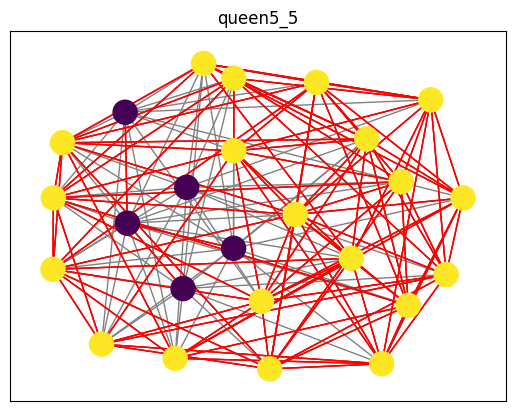

In [51]:
# Plot the colored graph
# 6_6: 1, 7_7: 6, 8_8: 5, 11_11: 26
bad_edges = get_bad_edges(best_coloring, edge_list)
print(len(bad_edges)/2)
plot_coloring(edge_list.cpu(), best_coloring.cpu(), bad_edges=bad_edges, title=graph.split('.')[0])
